In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-fin/final_data.csv


In [2]:
# Reading Data
import json, os
import pandas as pd
# Data Preprocessing
import re, nltk, string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pickle 
import datasets


2024-07-28 08:35:00.459615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 08:35:00.459748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 08:35:00.583188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Replace the file path with your actual file path
file_path = "/kaggle/input/nlp-fin/final_data.csv"

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path)


In [4]:
print(data.describe())


       sentence                       section
count    150000                        150000
unique    74215                             6
top     Item 3.  Market Position and Strategy
freq        584                         25000


In [5]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'section' column
data['section_encoded'] = label_encoder.fit_transform(data['section'])

# Display the first few rows to check the encoding
print(data[['section', 'section_encoded']].head())


                        section  section_encoded
0  Market Position and Strategy                2
1  Market Position and Strategy                2
2  Market Position and Strategy                2
3  Market Position and Strategy                2
4  Market Position and Strategy                2


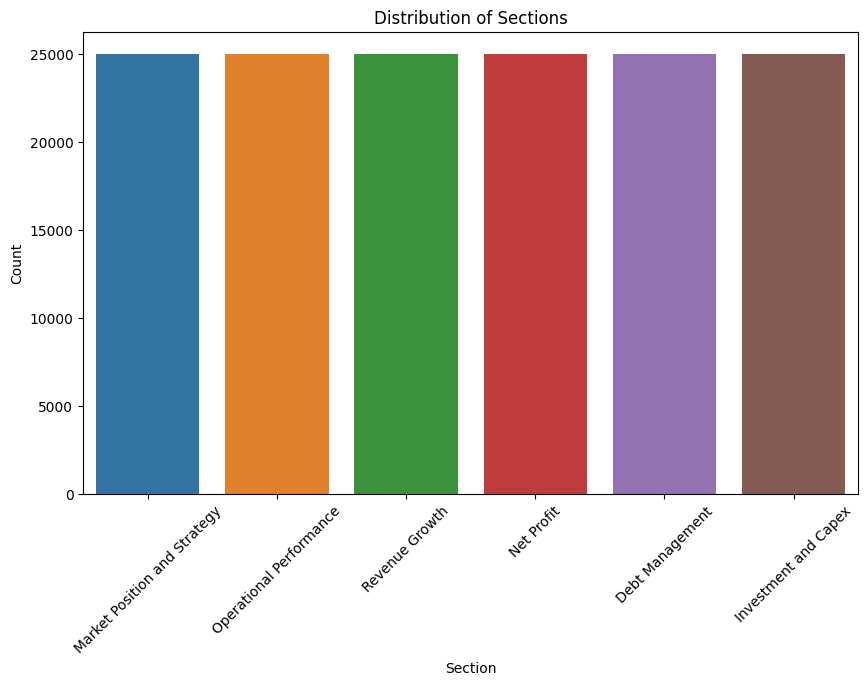

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Count plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='section', order=data['section'].value_counts().index)
plt.title('Distribution of Sections')
plt.xlabel('Section')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [7]:
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaModel, RobertaTokenizer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import string

nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #English language's stop words

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
    
    words = s.split() # split the string into list of words
    words = [word for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    
    return s


In [9]:
# Preprocess text
data['sentence'] = data['sentence'].apply(textpreprocess)


In [10]:
import tensorflow as tf
from transformers import TFRobertaModel
import torch
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [11]:
# Tokenizer and max_length
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 128

# Tokenization function
def tokenize_sentences(sentences):
    input_ids, attention_masks = [], []
    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Prepare data
sentences = data['sentence'].values
labels = data['section_encoded'].values

input_ids, attention_masks = tokenize_sentences(sentences)

# Split data into training and validation sets
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
# Define dataset class
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Create datasets and dataloaders
train_dataset = TextDataset(train_inputs, train_masks, train_labels)
val_dataset = TextDataset(val_inputs, val_masks, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaModel
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

class RCNNRobertaClassifier(nn.Module):
    def __init__(self, n_classes):
        super(RCNNRobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.conv = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256 * 4, n_classes)  # Adjusted input size

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        sequence_output = sequence_output.permute(0, 2, 1)
        conv_output = torch.relu(self.conv(sequence_output))
        conv_output = conv_output.permute(0, 2, 1)
        lstm_output, _ = self.lstm(conv_output)
        avg_pool = torch.mean(lstm_output, 1)
        max_pool, _ = torch.max(lstm_output, 1)
        pooled_output = torch.cat((avg_pool, max_pool), 1)
        logits = self.fc(pooled_output)
        return logits


In [15]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += len(labels)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


In [16]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += len(labels)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


In [17]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, optimizer, and scheduler
model = RCNNRobertaClassifier(n_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Assuming train_loader and val_loader are already defined

# Training with early stopping
num_epochs = 20
best_val_accuracy = 0
patience = 3
early_stopping_counter = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    # Validation
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stopping_counter = 0
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


Training: 100%|██████████| 7500/7500 [26:21<00:00,  4.74it/s]


Training Loss: 0.9643, Accuracy: 0.6475


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.93it/s]


Validation Loss: 0.7175, Accuracy: 0.7454
Epoch 2/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.6411, Accuracy: 0.7665


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.94it/s]


Validation Loss: 0.5718, Accuracy: 0.7872
Epoch 3/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.5229, Accuracy: 0.8078


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.96it/s]


Validation Loss: 0.5422, Accuracy: 0.8033
Epoch 4/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.4535, Accuracy: 0.8298


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.96it/s]


Validation Loss: 0.5158, Accuracy: 0.8215
Epoch 5/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.4172, Accuracy: 0.8397


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.96it/s]


Validation Loss: 0.4751, Accuracy: 0.8247
Epoch 6/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.3854, Accuracy: 0.8497


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.96it/s]


Validation Loss: 0.4729, Accuracy: 0.8271
Epoch 7/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.3625, Accuracy: 0.8576


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.95it/s]


Validation Loss: 0.4528, Accuracy: 0.8323
Epoch 8/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.3451, Accuracy: 0.8616


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.92it/s]


Validation Loss: 0.5010, Accuracy: 0.8327
Epoch 9/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.3312, Accuracy: 0.8664


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.97it/s]


Validation Loss: 0.4408, Accuracy: 0.8367
Epoch 10/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.3187, Accuracy: 0.8695


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.97it/s]


Validation Loss: 0.4814, Accuracy: 0.8371
Epoch 11/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.3073, Accuracy: 0.8731


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.99it/s]


Validation Loss: 0.4648, Accuracy: 0.8364
Epoch 12/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.2996, Accuracy: 0.8753


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.99it/s]


Validation Loss: 0.4772, Accuracy: 0.8379
Epoch 00012: reducing learning rate of group 0 to 5.0000e-06.
Epoch 13/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.2476, Accuracy: 0.8911


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.97it/s]


Validation Loss: 0.4917, Accuracy: 0.8425
Epoch 14/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.2342, Accuracy: 0.8956


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.97it/s]


Validation Loss: 0.4955, Accuracy: 0.8426
Epoch 15/20


Training: 100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]


Training Loss: 0.2289, Accuracy: 0.8967


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.91it/s]


Validation Loss: 0.5153, Accuracy: 0.8427
Epoch 00015: reducing learning rate of group 0 to 5.0000e-07.
Epoch 16/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.2209, Accuracy: 0.8992


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.92it/s]


Validation Loss: 0.5244, Accuracy: 0.8423
Epoch 17/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.2193, Accuracy: 0.8993


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.92it/s]


Validation Loss: 0.5285, Accuracy: 0.8424
Epoch 18/20


Training: 100%|██████████| 7500/7500 [26:20<00:00,  4.75it/s]


Training Loss: 0.2190, Accuracy: 0.8997


Evaluating: 100%|██████████| 1875/1875 [01:57<00:00, 15.91it/s]


Validation Loss: 0.5309, Accuracy: 0.8424
Epoch 00018: reducing learning rate of group 0 to 5.0000e-08.
Early stopping triggered


<All keys matched successfully>

In [18]:
import pickle
import torch

# Save the entire model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)